#### Importing packages

In [1]:
# Importing the scripts
from webdesign.polls.scripts import preprocess
from webdesign.polls.scripts import categorize
from webdesign.polls.scripts import analyze
from webdesign.polls.scripts import visualize
from webdesign.polls.scripts import forecast

# Importing other packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

#### Workflow 

In [2]:
def single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size=None,custom_range=None,title=None):
    pp_ts = preprocess.fill_dates(input_ts,freq) 
    pp_ts = preprocess.fill_values(pp_ts,fill_method)
    pp_ts = preprocess.smoothing(pp_ts,smooth_window)

    if cat_method[0] == 'L':
        cat_ts, bin_bounds = categorize.level_categorize(pp_ts,cat_method,num_bins,custom_range)
    else:
        trend_ts, (cat_ts, bin_bounds) = categorize.trend_categorize(pp_ts,cat_method,win_size,num_bins,custom_range)

    if workflow_type == 'single':
        ### display plots and table only for single time series workflow
        if cat_method[0] == 'L':
            visualize.single_ts_level_plot_nosave(pp_ts,cat_ts,bin_bounds,title)
        else:
            visualize.single_ts_trend_plot_nosave(pp_ts,trend_ts,cat_ts,bin_bounds,title)
        display(analyze.single_ts_analyze(cat_ts,bin_bounds,freq))
    else:
        return cat_ts

### Single Time Series

#### Parameters

In [3]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'T-rate'
num_bins = 8
win_size = 14
#custom_range = (0,500)

In [4]:
workflow_type = 'single'
freq = 'D'
input_ts = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_covid_admissions.csv',parse_dates=['date'])

In [5]:
input_ts

,date,value
0,2020-09-01,81.0
1,2020-09-02,74.0
2,2020-09-03,85.0
3,2020-09-04,80.0
4,2020-09-05,85.0
...,...,...
1010,2023-06-08,7.0
1011,2023-06-09,11.0
1012,2023-06-10,10.0
1013,2023-06-11,9.0


,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,R1,"(-290.29, -217.71)",0,0.0%,0.0
1,R2,"(-217.71, -145.14)",10,1.0%,10.0
2,R3,"(-145.14, -72.57)",32,3.2%,16.0
3,R4,"(-72.57, 0.0)",517,51.65%,24.6
4,R5,"(0.0, 72.57)",422,42.16%,21.1
5,R6,"(72.57, 145.14)",5,0.5%,2.5
6,R7,"(145.14, 217.71)",6,0.6%,3.0
7,R8,"(217.71, 290.29)",9,0.9%,9.0


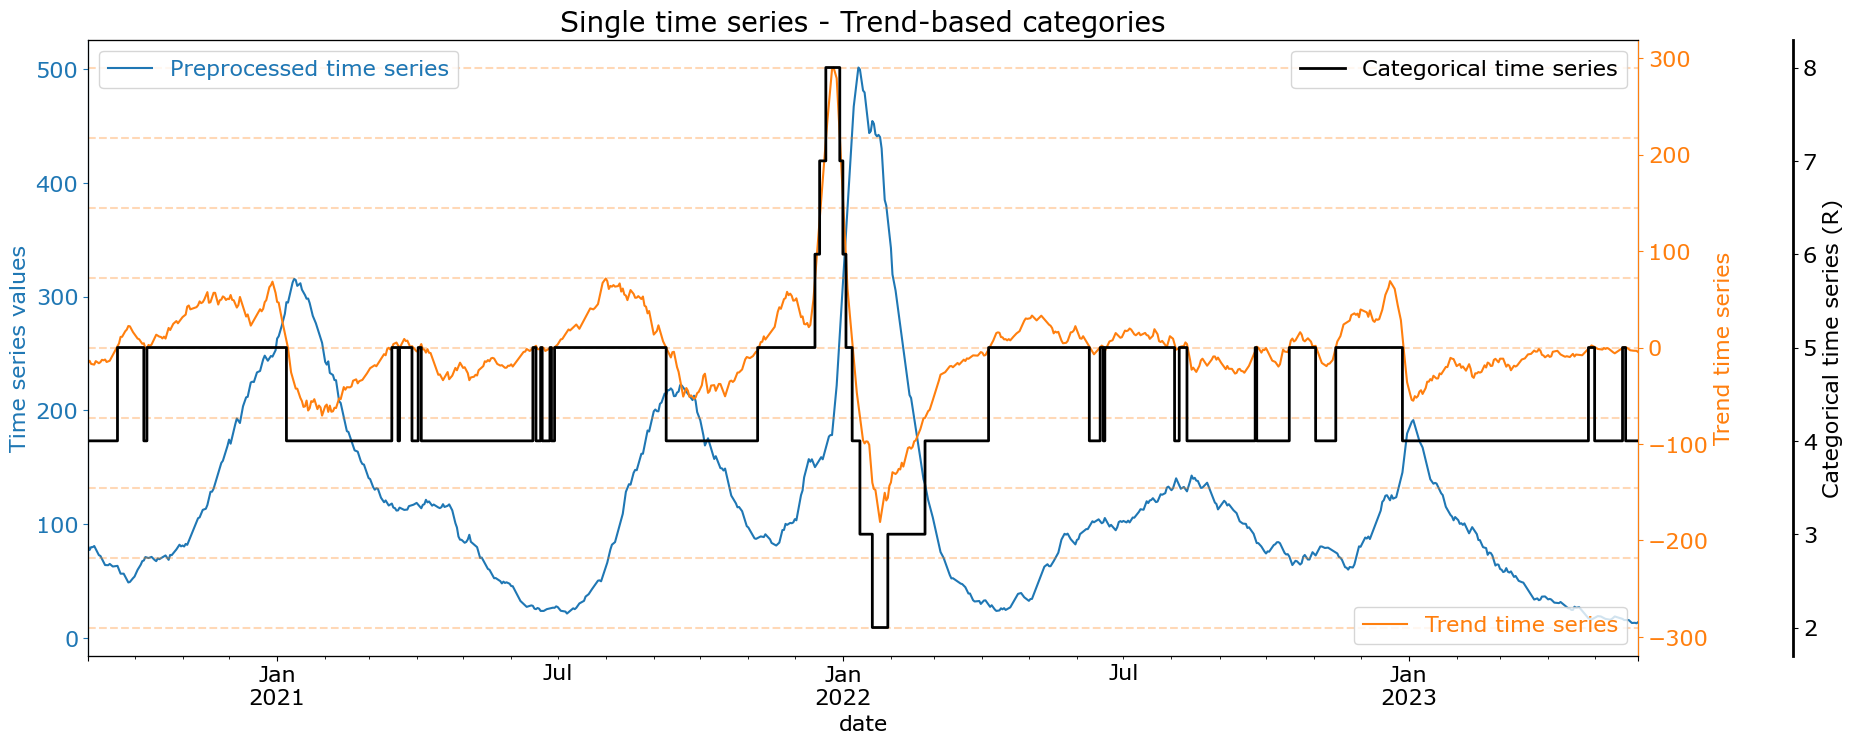

In [6]:
single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)

### Multi Time series

#### Parameters

In [7]:
### preprocess parameters
fill_method = 'linear'
smooth_window = 7

### categorize parameters
cat_method = 'L-qcut'
num_bins = 8
win_size = 14
#custom_range = (0,500)

In [8]:
workflow_type = 'multi-signal'
freq = 'W'
input_df = pd.read_csv('/Users/vsriniv/Documents/Research/Github/PEpiTA/data/va_cases_cli_viralload.csv',parse_dates=['date'],index_col=0)

            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**cases_reported**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(1966.14, 6708.38)",11,12.79%,5.5
1,Q2,"(6708.38, 8428.75)",11,12.79%,2.8
2,Q3,"(8428.75, 10923.11)",10,11.63%,1.7
3,Q4,"(10923.11, 13196.71)",11,12.79%,1.6
4,Q5,"(13196.71, 17153.25)",11,12.79%,1.8
5,Q6,"(17153.25, 19550.31)",10,11.63%,2.0
6,Q7,"(19550.31, 25281.38)",11,12.79%,3.7
7,Q8,"(25281.38, 80100.29)",11,12.79%,11.0


            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**cli_visits**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(7374.57, 10059.07)",11,12.79%,5.5
1,Q2,"(10059.07, 13505.0)",11,12.79%,3.7
2,Q3,"(13505.0, 15175.02)",10,11.63%,2.0
3,Q4,"(15175.02, 15454.93)",11,12.79%,3.7
4,Q5,"(15454.93, 16809.86)",11,12.79%,2.2
5,Q6,"(16809.86, 19152.64)",10,11.63%,2.0
6,Q7,"(19152.64, 23086.0)",11,12.79%,3.7
7,Q8,"(23086.0, 36445.71)",11,12.79%,5.5


            cases_reported  cli_visits  viralload
date                                             
2021-09-12         24987.0     26380.0  28.426552
2021-09-19         22092.0     23494.0  28.086507
2021-09-26         19486.0     21279.0  28.239338
2021-10-03         17243.0     19675.0  27.385247
2021-10-10         14071.0     16433.0  27.755509
...                    ...         ...        ...
2023-04-02          2238.0      9291.0  27.521928
2023-04-09          1734.0      8987.0  27.704354
2023-04-16          1631.0      8758.0  27.375865
2023-04-23          1409.0      8548.0  27.417587
2023-04-30          1477.0      8736.0  26.440917

[86 rows x 3 columns]


**viralload**

,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(27.29, 27.81)",11,12.79%,5.5
1,Q2,"(27.81, 28.06)",11,12.79%,3.7
2,Q3,"(28.06, 28.41)",10,11.63%,1.7
3,Q4,"(28.41, 28.68)",11,12.79%,1.6
4,Q5,"(28.68, 29.02)",11,12.79%,2.2
5,Q6,"(29.02, 29.28)",10,11.63%,2.0
6,Q7,"(29.28, 29.69)",11,12.79%,2.2
7,Q8,"(29.69, 30.21)",11,12.79%,5.5


,cases_reported,cli_visits,viralload
2021-09-12,Q7,Q8,Q4
2021-09-19,Q7,Q8,Q3
2021-09-26,Q7,Q8,Q3
2021-10-03,Q7,Q7,Q2
2021-10-10,Q7,Q7,Q2
...,...,...,...
2023-04-02,Q1,Q2,Q1
2023-04-09,Q1,Q2,Q1
2023-04-16,Q1,Q2,Q1
2023-04-23,Q1,Q1,Q1


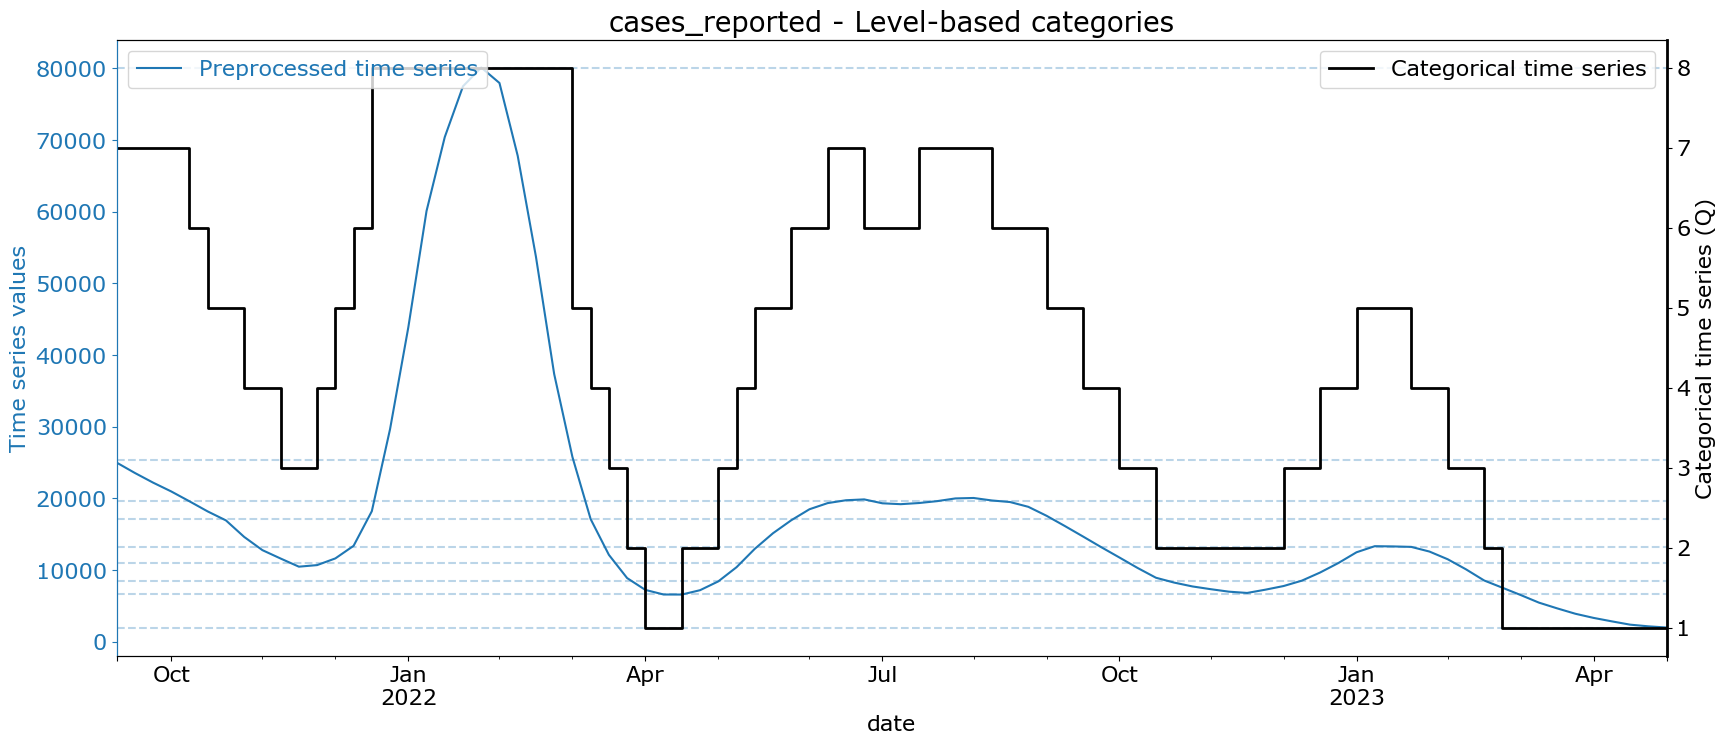

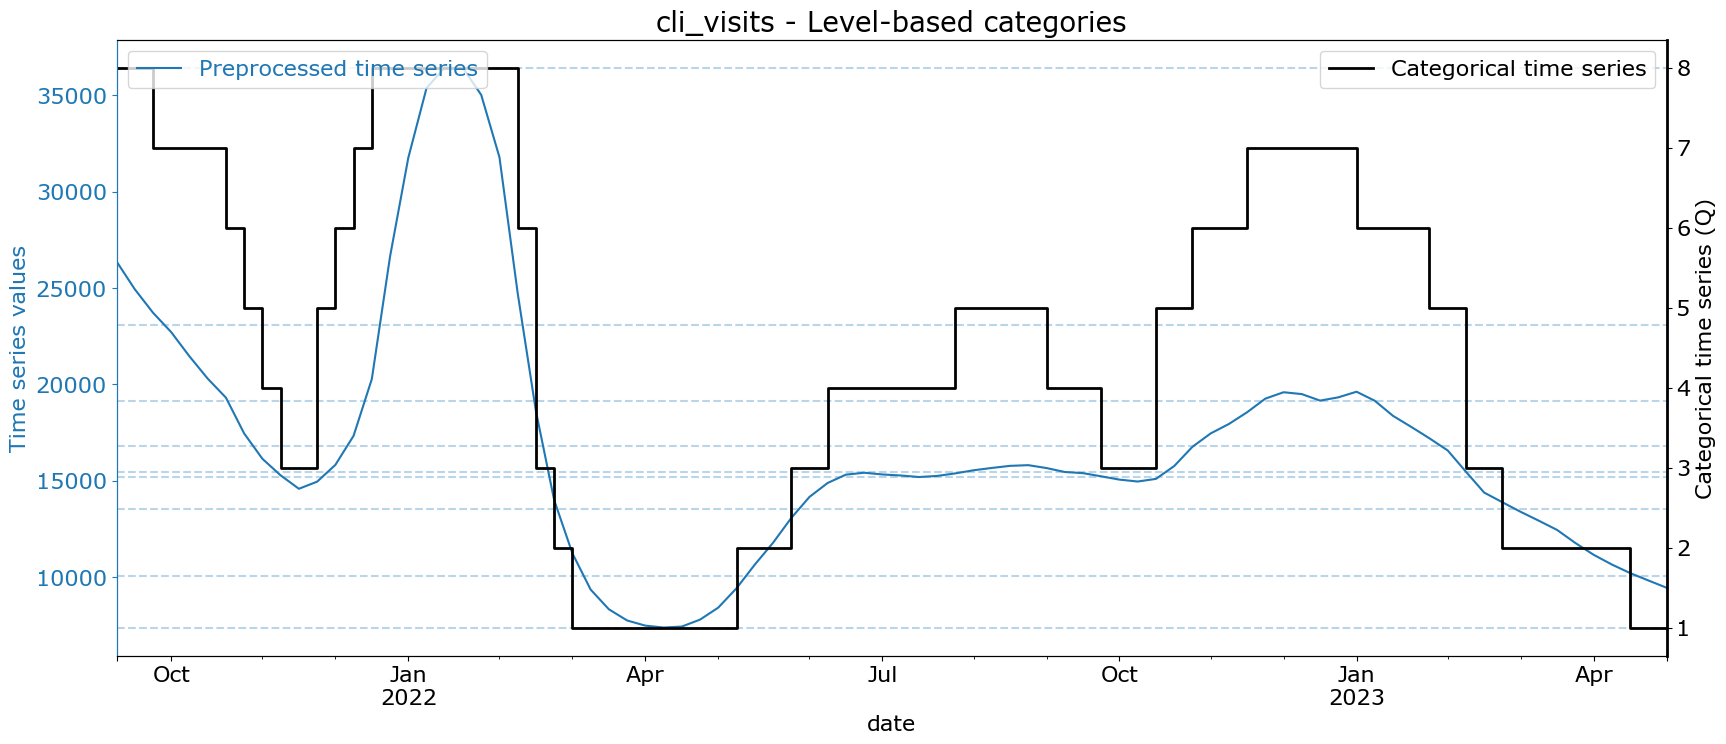

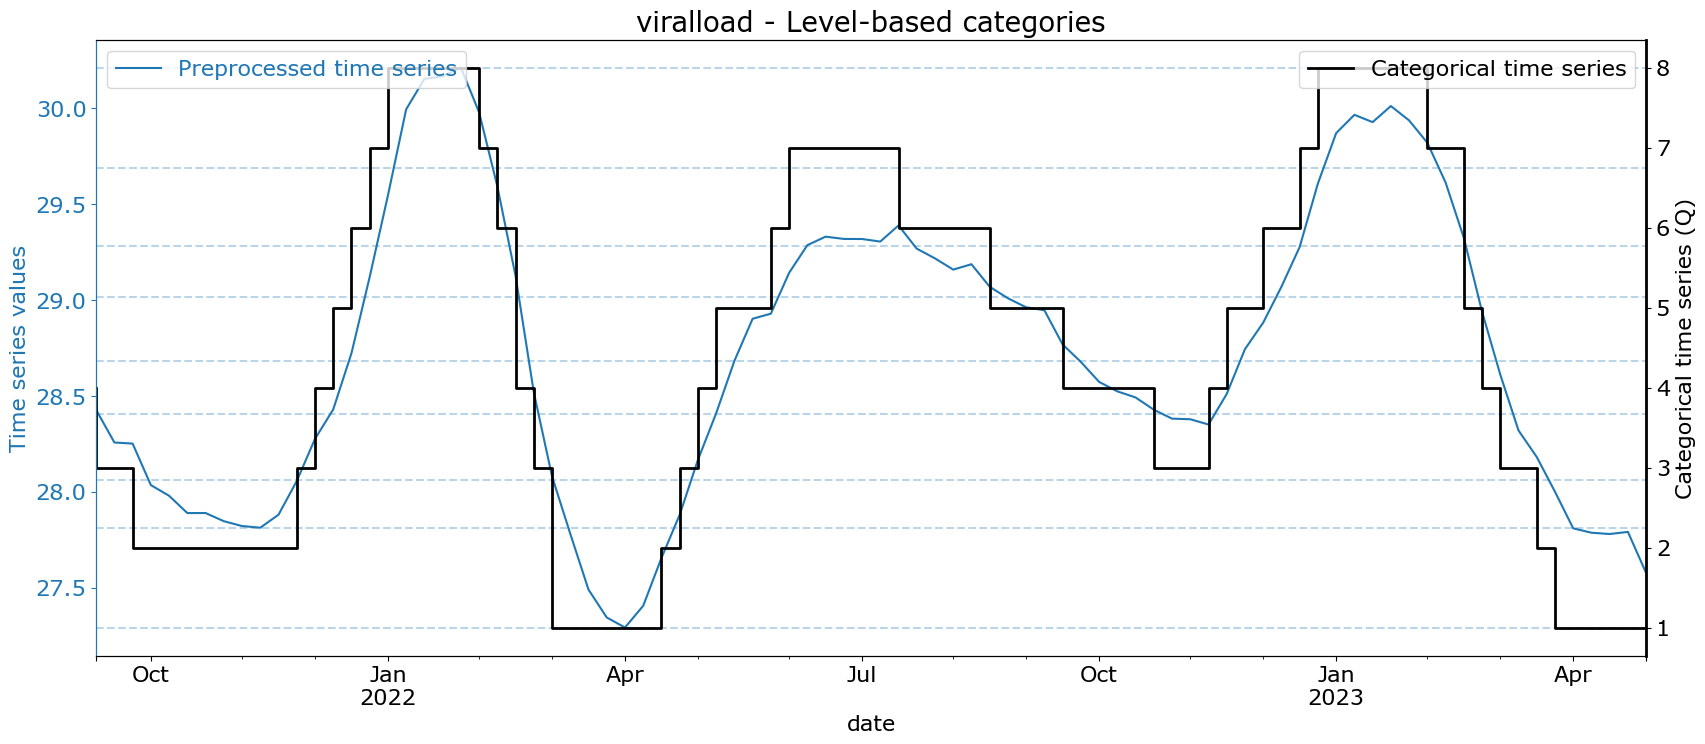

In [9]:
cat_df = pd.DataFrame()
for column in input_df.columns:
    print(input_df)
    signal_ts = input_df[[column]]
    signal_ts.columns = ['value']
    input_ts = signal_ts.reset_index()
    printmd("**"+column+"**")
    single_ts_workflow(input_ts,'single',freq,fill_method,smooth_window,cat_method,num_bins,win_size,title=column)
    cat_ts = single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins,win_size)
    cat_df = pd.concat([cat_df,cat_ts],axis=1)
cat_df.columns = input_df.columns
cat_df

In [10]:
visualize.multi_signal_plot(cat_df,cat_method)

'20240419160228403578.png'

In [11]:
chi_df, pval_df, csq_str_df = analyze.multi_ts_analyze(cat_df)

'20240419160228616301.png'

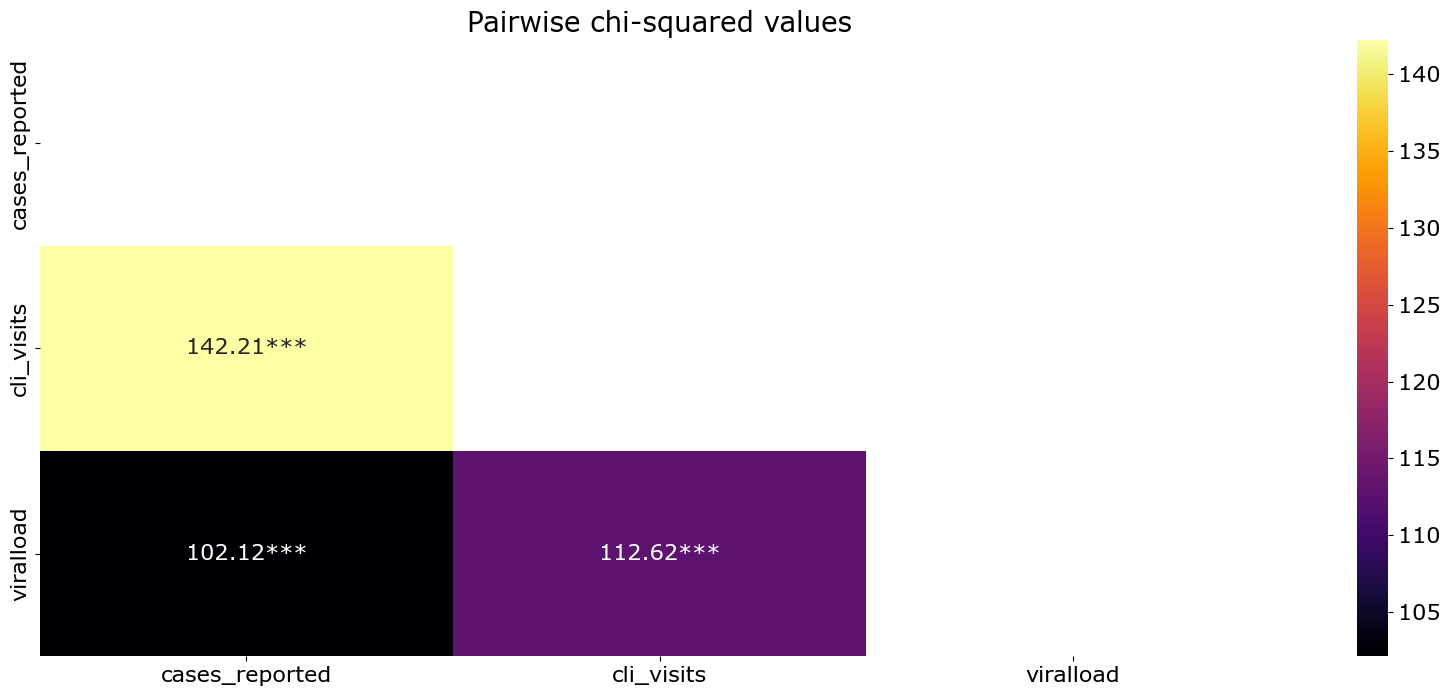

In [12]:
visualize.multi_cat_csq(chi_df,csq_str_df)

### Forecast

In [13]:
#qfct, cat_fct = forecast.fcast_example()
loc='US'
data_cutoff='2024-03-16'
obs_date=pd.to_datetime(data_cutoff)

fname='https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv'
df=pd.read_csv(fname,parse_dates=['date'])

input_ts=df.pivot(index='date',columns='location',values='value')[loc].reset_index()
input_ts.columns = ['date','value']

In [14]:
workflow_type = 'single'
freq = 'W'
fill_method = 'linear'
smooth_window = 1
cat_method = 'L-qcut'
num_bins = 8

In [15]:
input_ts

,date,value
0,2022-02-12,1237
1,2022-02-19,1512
2,2022-02-26,1669
3,2022-03-05,1889
4,2022-03-12,2223
...,...,...
109,2024-03-16,7273
110,2024-03-23,5906
111,2024-03-30,5438
112,2024-04-06,4957


,category,bin_boundaries,number_of_occurrences,percent_time_spent,average_duration_spent
0,Q1,"(572.0, 708.25)",15,13.16%,5.0
1,Q2,"(708.25, 908.5)",14,12.28%,2.0
2,Q3,"(908.5, 1251.62)",14,12.28%,2.3
3,Q4,"(1251.62, 1889.5)",14,12.28%,2.8
4,Q5,"(1889.5, 3119.0)",14,12.28%,2.8
5,Q6,"(3119.0, 5317.75)",14,12.28%,2.8
6,Q7,"(5317.75, 11002.5)",14,12.28%,3.5
7,Q8,"(11002.5, 26602.0)",15,13.16%,7.5


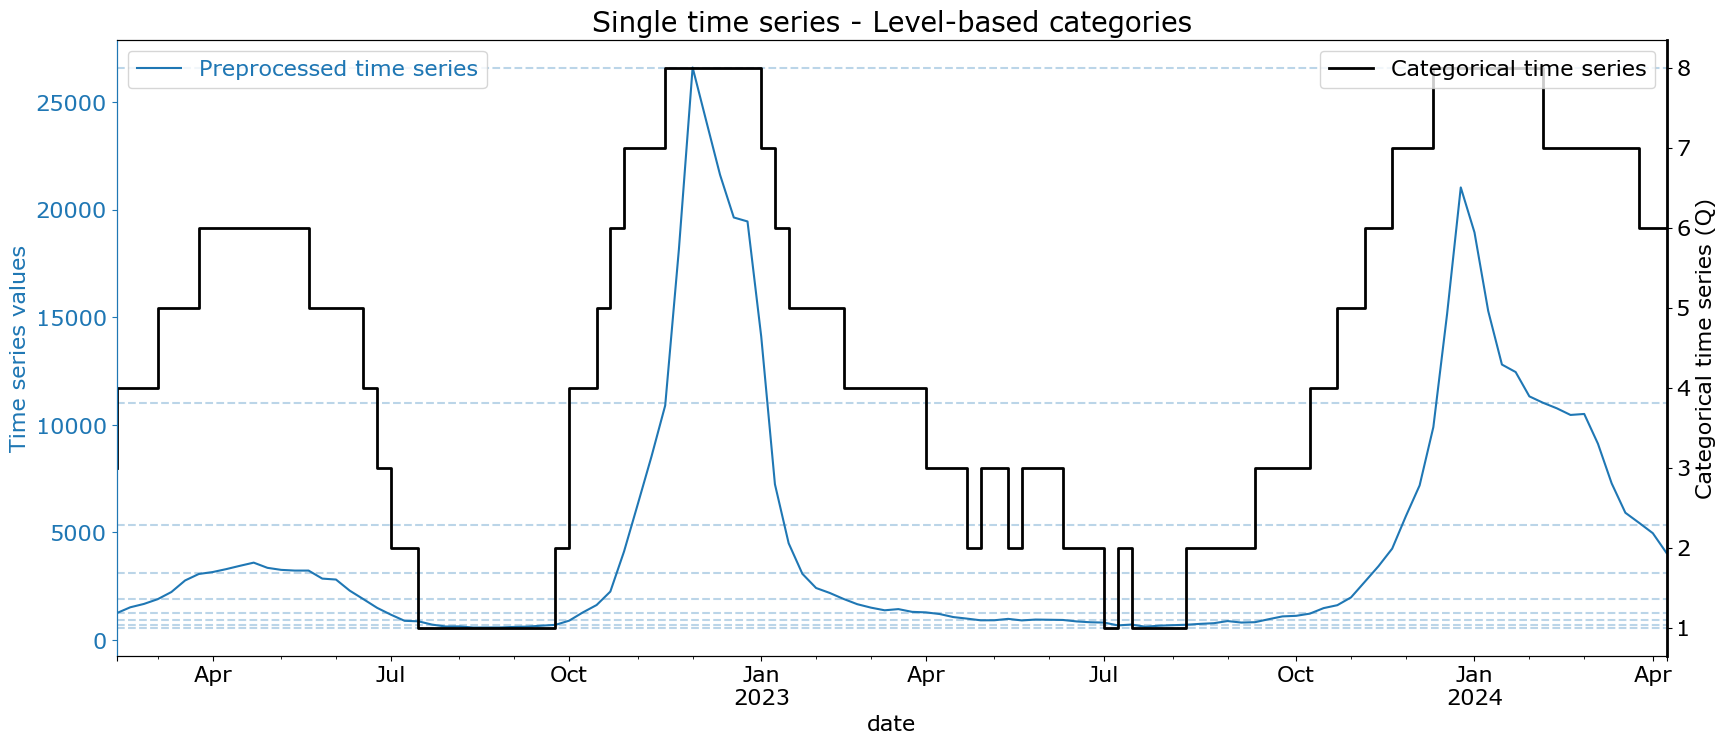

In [16]:
single_ts_workflow(input_ts,workflow_type,freq,fill_method,smooth_window,cat_method,num_bins)

In [17]:
qfct, cat_fct = forecast.ARIMA_func(input_ts,cat_method,num_bins)

'20240419160231069589.png'

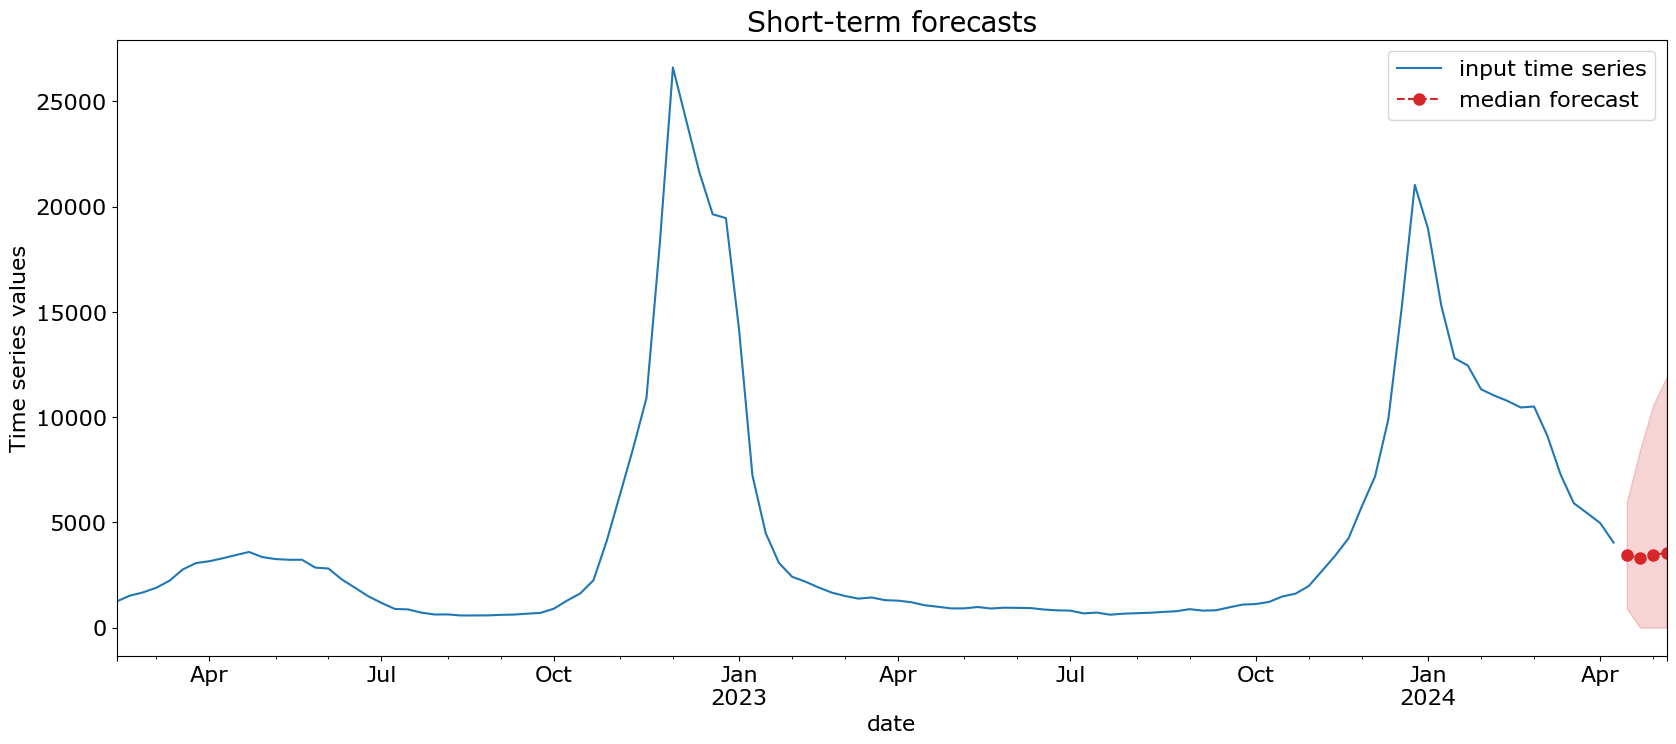

In [18]:
visualize.fcast_plot(input_ts,qfct)

'20240419160231585274.png'

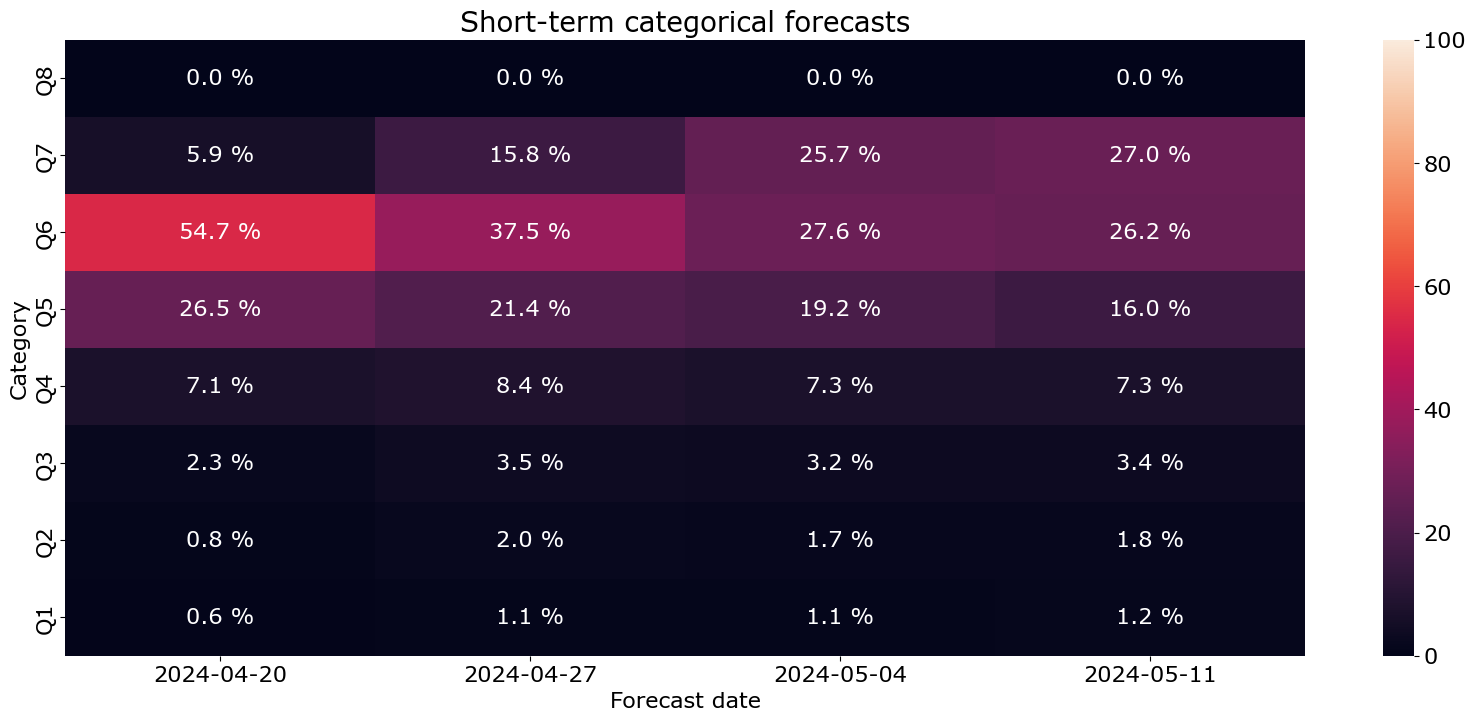

In [19]:
visualize.cat_fcast_plot(cat_fct)

In [20]:
input_ts.to_csv('/Users/vsriniv/Desktop/test_ts.csv',index=None)

In [21]:
cat_fct.groupby('target_end_date')['value'].sum()

target_end_date
2024-04-20    0.978870
2024-04-27    0.896760
2024-05-04    0.857956
2024-05-11    0.828860
Name: value, dtype: float64